In [34]:
# import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

In [35]:
df = pd.read_excel('../datasets/cleaned_orders.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22976 entries, 0 to 22975
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            22976 non-null  int64  
 1   customer_id                           22976 non-null  int64  
 2   order_time                            22976 non-null  object 
 3   item_quantity                         22976 non-null  int64  
 4   item_id                               22976 non-null  object 
 5   item_price                            22976 non-null  float64
 6   item_discount_raw                     22976 non-null  float64
 7   item_discount_percentage              22976 non-null  float64
 8   item_disc_bins_item_disc_null         22976 non-null  int64  
 9   item_disc_bins_item_disc_sub_twenty   22976 non-null  int64  
 10  item_disc_bins_item_disc_sub_forty    22976 non-null  int64  
 11  item_disc_bins_

In [36]:
# remove time from datetime so we can groupby later

df.drop(columns=df.columns[0], axis=1, inplace=True)
df['order_time'] = pd.to_datetime(df['order_time'])
df.head(2)

,customer_id,order_time,item_quantity,item_id,item_price,item_discount_raw,item_discount_percentage,item_disc_bins_item_disc_null,item_disc_bins_item_disc_sub_twenty,item_disc_bins_item_disc_sub_forty,item_disc_bins_item_disc_sub_sixty,item_disc_bins_item_disc_sub_eighty,item_disc_bins_item_disc_sub_hundred
0,0,2022-04-29 18:29:49+08:00,1,Arzuaga blanco,49.0,0.0,0.0,1,0,0,0,0,0
1,0,2022-04-29 18:29:49+08:00,1,Arzuaga reserva,94.0,0.0,0.0,1,0,0,0,0,0


In [37]:
df.columns

Index(['customer_id', 'order_time', 'item_quantity', 'item_id', 'item_price',
       'item_discount_raw', 'item_discount_percentage',
       'item_disc_bins_item_disc_null', 'item_disc_bins_item_disc_sub_twenty',
       'item_disc_bins_item_disc_sub_forty',
       'item_disc_bins_item_disc_sub_sixty',
       'item_disc_bins_item_disc_sub_eighty',
       'item_disc_bins_item_disc_sub_hundred'],
      dtype='object')

In [38]:
grouped = df[['order_time', 'item_id', 'item_quantity', 'item_price', 
              'item_disc_bins_item_disc_null', 
              'item_disc_bins_item_disc_sub_twenty',
              'item_disc_bins_item_disc_sub_forty',
              'item_disc_bins_item_disc_sub_sixty',
              'item_disc_bins_item_disc_sub_eighty',
              'item_disc_bins_item_disc_sub_hundred']]

In [39]:
groupedbyitem = grouped.groupby('item_id', group_keys=True).apply(lambda x:x)


In [40]:
groupedbyitem['item_id'].value_counts()

Glassware                          728
Wine Virgin                        325
Rara Neagră de Purcari 2020        110
Wine Nut                            86
Puchang Beichun 2015                81
                                  ... 
GT Spain                             1
Blink Wines                          1
Freehand Ormus Field Blend 2020      1
Fumo olive oil                       1
Muga Gift Set                        1
Name: item_id, Length: 4481, dtype: int64

In [41]:
sample = groupedbyitem[groupedbyitem['item_id']=='Rara Neagră de Purcari 2020']

## Just looking @ the sample data first

In [42]:
sample.sort_values(by='order_time', inplace=True)

/var/folders/j9/hl0rz3wj6yb5zwjtn6qjs8bh0000gn/T/ipykernel_7294/1515691136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.sort_values(by='order_time', inplace=True)


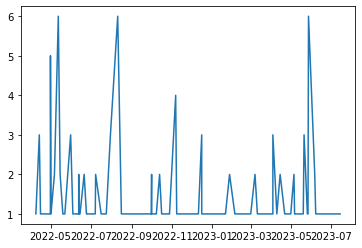

In [43]:
sample['item_id'].value_counts()
x = sample['order_time']
y = sample['item_quantity']
plt.plot(x,y)

In [44]:
sample.head(1)

,order_time,item_id,item_quantity,item_price,item_disc_bins_item_disc_null,item_disc_bins_item_disc_sub_twenty,item_disc_bins_item_disc_sub_forty,item_disc_bins_item_disc_sub_sixty,item_disc_bins_item_disc_sub_eighty,item_disc_bins_item_disc_sub_hundred
3775,2022-04-08 11:52:24+08:00,Rara Neagră de Purcari 2020,1,47.0,1,0,0,0,0,0


In [45]:
# remove the item name
sample.drop(columns=sample.columns[1], axis=1, inplace=True)

# group by order time
#sample = sample.groupby('order_time', group_keys=True).apply(lambda x:x)

/var/folders/j9/hl0rz3wj6yb5zwjtn6qjs8bh0000gn/T/ipykernel_7294/2963820660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.drop(columns=sample.columns[1], axis=1, inplace=True)


In [46]:
sample.head(2)

,order_time,item_quantity,item_price,item_disc_bins_item_disc_null,item_disc_bins_item_disc_sub_twenty,item_disc_bins_item_disc_sub_forty,item_disc_bins_item_disc_sub_sixty,item_disc_bins_item_disc_sub_eighty,item_disc_bins_item_disc_sub_hundred
3775,2022-04-08 11:52:24+08:00,1,47.0,1,0,0,0,0,0
5026,2022-04-08 14:57:17+08:00,1,47.0,1,0,0,0,0,0


### MLR using sklearn

/var/folders/j9/hl0rz3wj6yb5zwjtn6qjs8bh0000gn/T/ipykernel_7294/225775164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.sort_values(by='order_time', inplace=True)


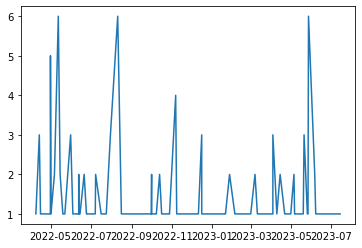

In [61]:
sample.sort_values(by='order_time', inplace=True)
x = sample['order_time']
y = sample['item_quantity']
plt.plot(x,y)

In [48]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 3775 to 15102
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype                                
---  ------                                --------------  -----                                
 0   order_time                            110 non-null    datetime64[ns, pytz.FixedOffset(480)]
 1   item_quantity                         110 non-null    int64                                
 2   item_price                            110 non-null    float64                              
 3   item_disc_bins_item_disc_null         110 non-null    int64                                
 4   item_disc_bins_item_disc_sub_twenty   110 non-null    int64                                
 5   item_disc_bins_item_disc_sub_forty    110 non-null    int64                                
 6   item_disc_bins_item_disc_sub_sixty    110 non-null    int64                                
 7   item_disc_bin

In [62]:
x = sample.drop(columns=['item_quantity'])
y = sample['item_quantity']

# change to timestamp objects
x['order_time'] = x['order_time'].apply(pd.Timestamp.timestamp)

In [63]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [64]:
#import sklearn
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(x_train, y_train)

LinearRegression()

In [65]:
import statsmodels.api as sm

# add constant so stats model will give you regression coefficients
x2 = sm.add_constant(x_train)


In [66]:
x2.head(3)

,const,order_time,item_price,item_disc_bins_item_disc_null,item_disc_bins_item_disc_sub_twenty,item_disc_bins_item_disc_sub_forty,item_disc_bins_item_disc_sub_sixty,item_disc_bins_item_disc_sub_eighty,item_disc_bins_item_disc_sub_hundred
13393,1.0,1.674269e+09,50.0,1,0,0,0,0,0
13940,1.0,1.655736e+09,50.0,1,0,0,0,0,0
21381,1.0,1.655023e+09,50.0,1,0,0,0,0,0


In [67]:
# refit regression model using statsmodels
model2 = sm.OLS(y_train, x2)
model2_fit = model2.fit()
print(model2_fit.summary())

                            OLS Regression Results                            
Dep. Variable:          item_quantity   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.356
Date:                Wed, 23 Aug 2023   Prob (F-statistic):              0.256
Time:                        13:31:34   Log-Likelihood:                -122.80
No. Observations:                  88   AIC:                             255.6
Df Residuals:                      83   BIC:                             268.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


/Users/caraloo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [68]:
# see predictions
y_pred = model.predict(x_test)

In [70]:
from sklearn import metrics

r2 = metrics.r2_score(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test,y_pred))

print('r2: ' + str(r2))
print('rmse: ' + str(rmse))

r2: 0.016511607477732393
rmse: 1.1050938817172271


## Dump

In [40]:
# train 80% and test 20%
train = sample[:int(0.8*(len(sample)))]
test = sample[int(0.8*(len(sample))):]

dates = sample['order_time']
data = sample[['item_quantity', 'item_price',
               'item_disc_bins_item_disc_null', 
               'item_disc_bins_item_disc_sub_twenty',
               'item_disc_bins_item_disc_sub_forty',
               'item_disc_bins_item_disc_sub_sixty',
               'item_disc_bins_item_disc_sub_eighty',
               'item_disc_bins_item_disc_sub_hundred']]

data = data.astype(float)
data.index = pd.DatetimeIndex(dates)

# import VAR model and fit 
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(test))

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).